# Import Library

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import random
import cv2
import os

In [6]:
root = './input'

train_dir = Path(f'{root}/training/training/')
test_dir = Path(f'{root}/validation/validation/')

# Define Constants

In [7]:
FAST_RUN = False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE = 64
SEED = 100

# Prepare Traning Data

In [8]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
label_df = pd.read_csv(f"{root}/monkey_labels.txt", names=cols, skiprows=1)
label_df

Label                Latin Name                      Common Name  \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

   Train Images  Validation Images  
0           131                 26  
1           139                 28  
2           137                 27  
3           152                 30  
4           131                 26  
5           141                 28  
6           132                 26  
7           142                 28  
8           133                 27  
9           132                 26

In [9]:
labels = label_df['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [10]:
def image_show(num_image,label):

    for i in range(num_image):
        imgdir = Path(f'{root}/training/training/' + label)
        imgfile = random.choice(os.listdir(imgdir))
        img = cv2.imread(f'{root}/training/training/'+ label +'/'+ imgfile)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()


 pygmy_marmoset                


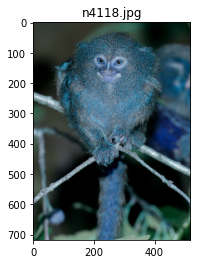

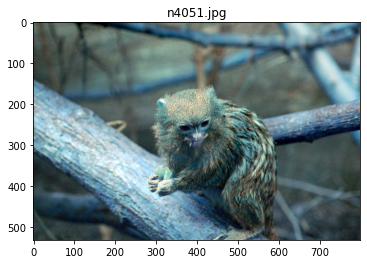

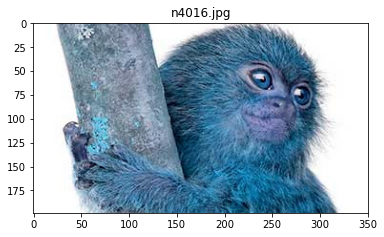

In [11]:
print(labels[4])
image_show(3,'n4')

In [12]:
# Training generator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [13]:
def get_net(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), strides=2))
    model.add(Activation('relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=2))
    model.add(Activation('relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=2))
    model.add(Activation('relu'))

    model.add(Conv2D(512, (1, 1), strides=2))
    model.add(Activation('relu'))
    model.add(Conv2D(num_classes, (1, 1)))
    model.add(GlobalAvgPool2D())
    model.add(Activation('softmax'))

    return model

num_classes = 10
net = get_net(num_classes)
net.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [15]:
filepath=("monkey.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

epochs = 50

history = net.fit(train_generator,
                              steps_per_epoch= train_num // BATCH_SIZE,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // BATCH_SIZE,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/50
 5/17 [=======>......................] - ETA: 15s - loss: 0.8573 - acc: 0.6594

KeyboardInterrupt: 

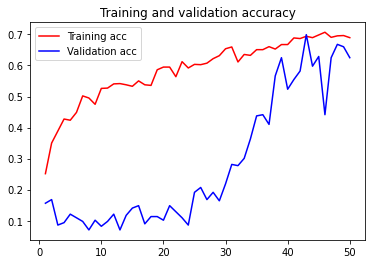

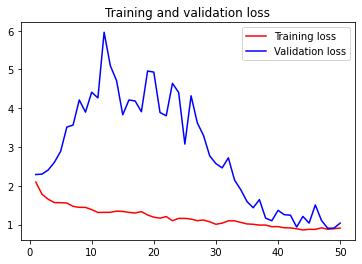

In [16]:
def visualize_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    plt.legend()
    
    plt.show()
    
visualize_history(history)

# Save Model

In [17]:
net.save_weights("model1.h5")

# Predict

In [18]:
predict = net.predict(validation_generator, steps=np.ceil(validation_num/BATCH_SIZE))

### See predicted result with images

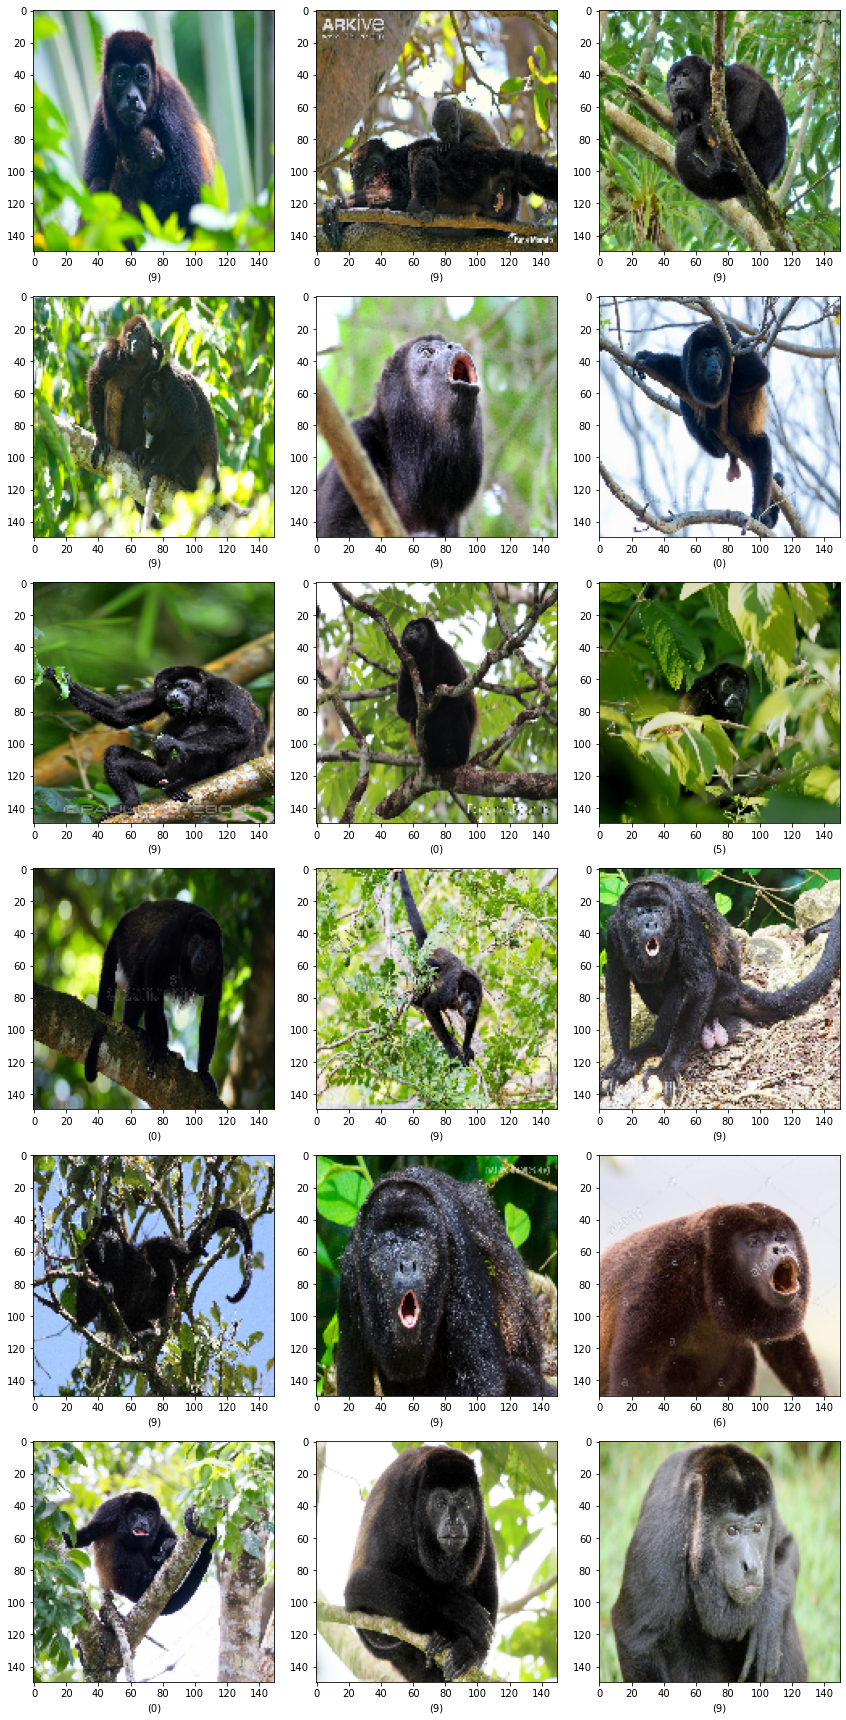

In [19]:
plt.figure(figsize=(12, 24))
img, null = validation_generator[0]
for i in range(18):
    plt.subplot(6, 3, i+1)
    plt.imshow(img[i])
    plt.xlabel('(' + "{}".format(np.argmax(predict, axis=-1)[i]) + ')' )
plt.tight_layout()
plt.show()

# Transfer Learning

In [20]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

IMAGE_SHAPE = IMAGE_SIZE + (IMAGE_CHANNELS, )

model = VGG16(include_top=False, input_shape=IMAGE_SHAPE)
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
base_learning_rate = 0.0001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

58900480/58889256 [==============================] - 13s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________________________

In [21]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_generator)

C:\Users\1111\anaconda3\lib\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


5/5 [==============================] - 13s 2s/step - loss: 0.7163 - accuracy: 0.0993


In [22]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator)

Epoch 1/10
18/18 [==============================] - 227s 13s/step - loss: 0.3571 - accuracy: 0.1266 - val_loss: 0.3101 - val_accuracy: 0.2206
Epoch 2/10
18/18 [==============================] - 233s 13s/step - loss: 0.2993 - accuracy: 0.2304 - val_loss: 0.2801 - val_accuracy: 0.3971
Epoch 3/10
18/18 [==============================] - 372s 21s/step - loss: 0.2688 - accuracy: 0.3506 - val_loss: 0.2262 - val_accuracy: 0.5184
Epoch 4/10
18/18 [==============================] - 503s 28s/step - loss: 0.2168 - accuracy: 0.5319 - val_loss: 0.1819 - val_accuracy: 0.6250
Epoch 5/10
18/18 [==============================] - 268s 14s/step - loss: 0.1678 - accuracy: 0.6430 - val_loss: 0.1811 - val_accuracy: 0.6581
Epoch 6/10
18/18 [==============================] - 280s 16s/step - loss: 0.1559 - accuracy: 0.6849 - val_loss: 0.1415 - val_accuracy: 0.7022
Epoch 7/10
18/18 [==============================] - 267s 15s/step - loss: 0.1187 - accuracy: 0.7760 - val_loss: 0.1010 - val_accuracy: 0.8125
Epoch 

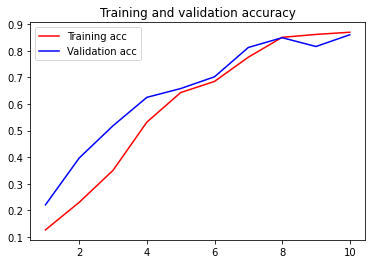

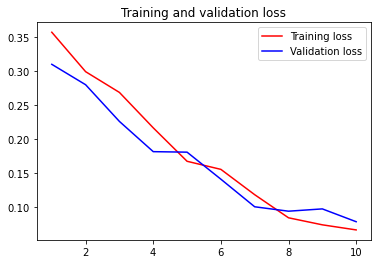

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
    
plt.show()

In [24]:
model.save_weights("model2.h5")

In [25]:
predict = model.predict(validation_generator, steps=np.ceil(validation_num/BATCH_SIZE))

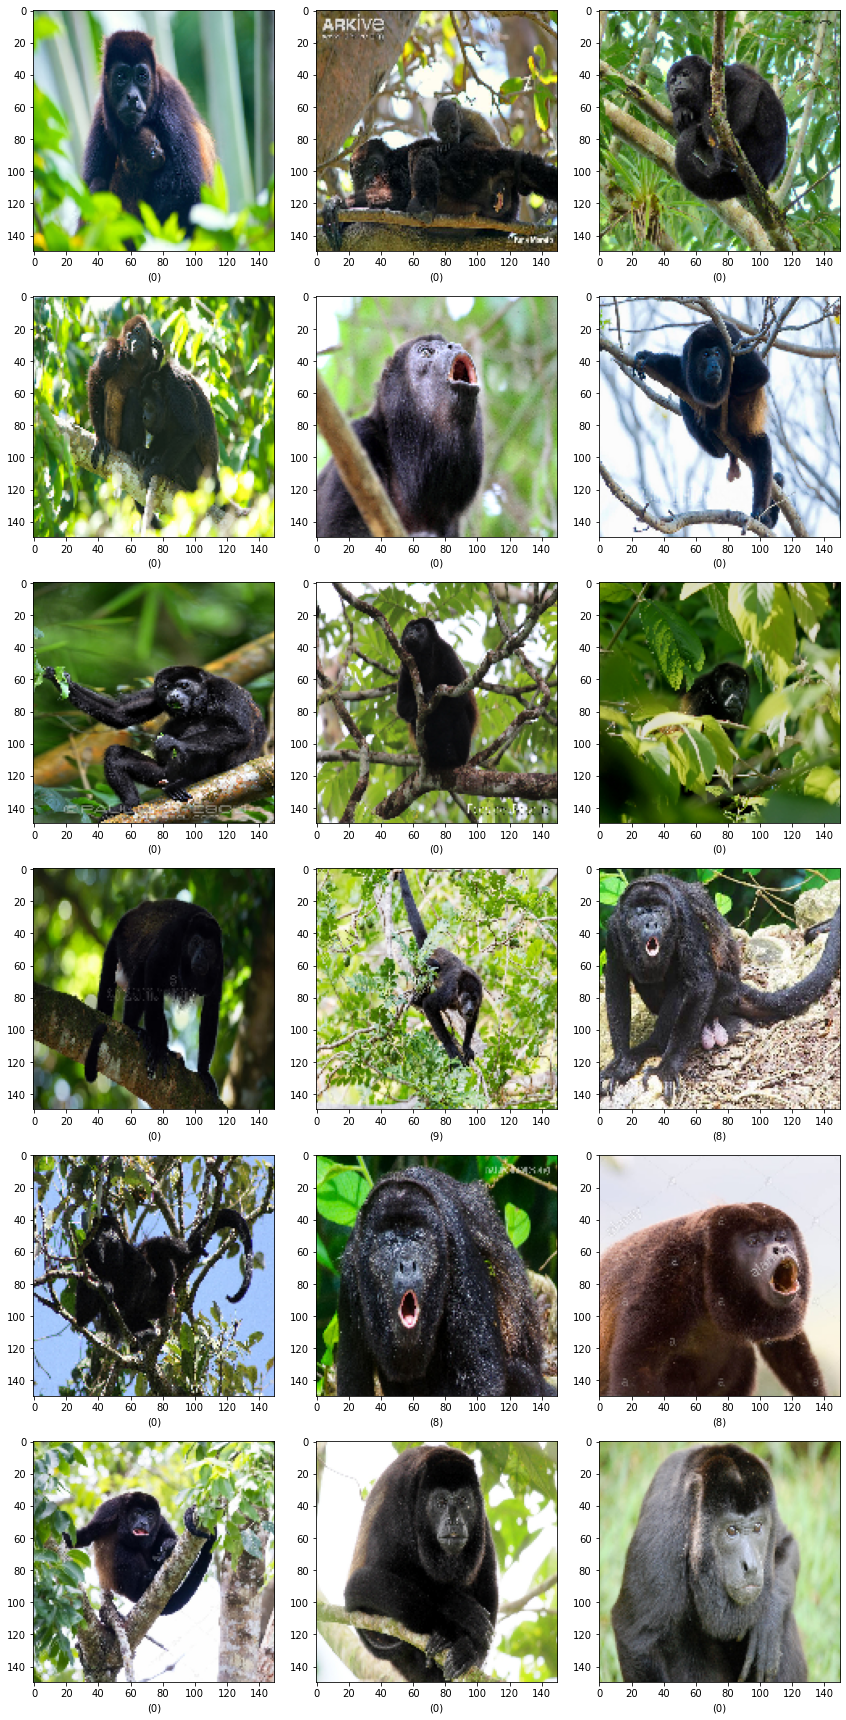

In [26]:
plt.figure(figsize=(12, 24))
img, null = validation_generator[0]
for i in range(18):
    plt.subplot(6, 3, i+1)
    plt.imshow(img[i])
    plt.xlabel('(' + "{}".format(np.argmax(predict, axis=-1)[i]) + ')' )
plt.tight_layout()
plt.show()